# Создание ETL системы

ETL система - совокупность ETL процессов. Для DWH характерно большое количество etl процессов, что затрудняет менеджмент потоков. Кроме того, etl процессы периодичны и атомарные операции над данными идут не параллельно, а последовательно (следующая зависит от результатов выполения предыдущей). 

Для обеспечения периодического запуска скриптов, можно использовать cron. Классический демон в системах класса UNIX, использующийся для периодического выполнения заданий в определённое время. Регулярные действия описываются инструкциями, помещенными в файлы crontab и в специальные каталоги. Но он не поможет нам с зависимостями.

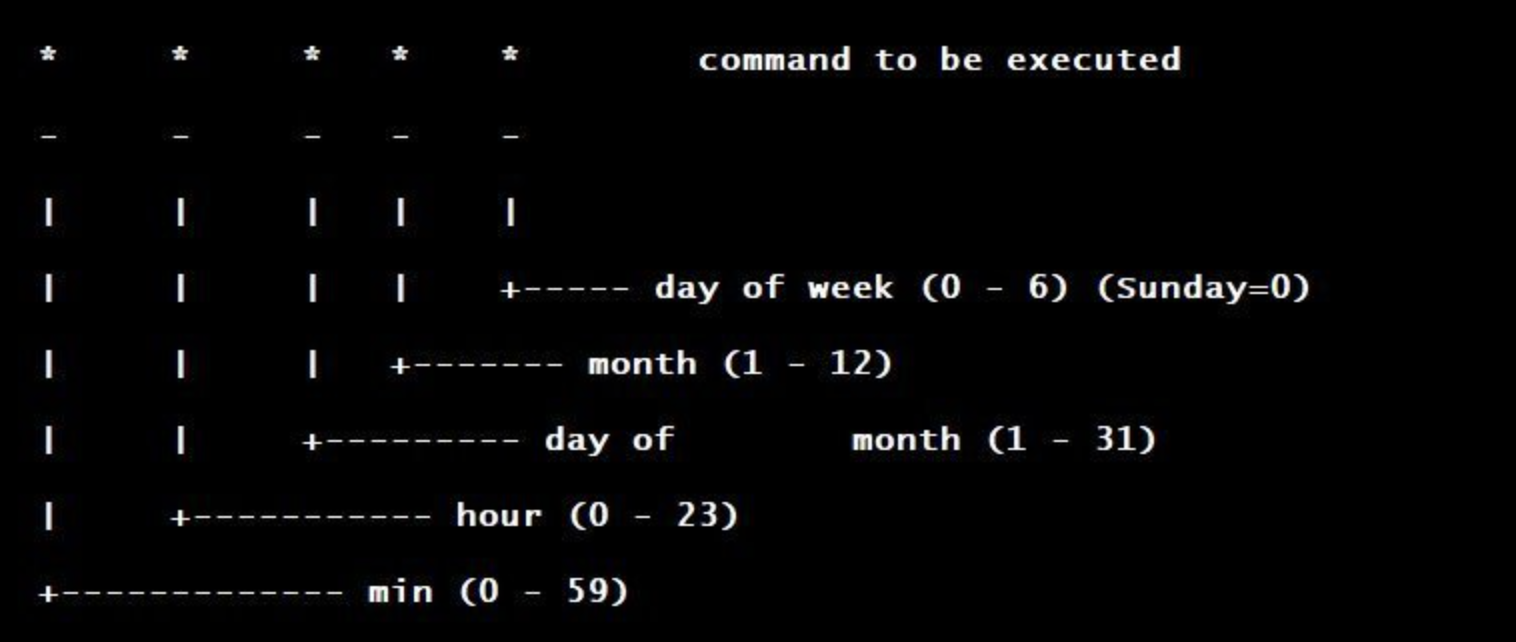

Самые популярные системы, поддерживающие зависимости и имеющие встроенные шедулеры:

    • Apache Airflow
    • Luigi

## Apache Airflow 

Airflow - это набор библиотек для разработки, планирования и мониторинга рабочих процессов. 

Архитектура:

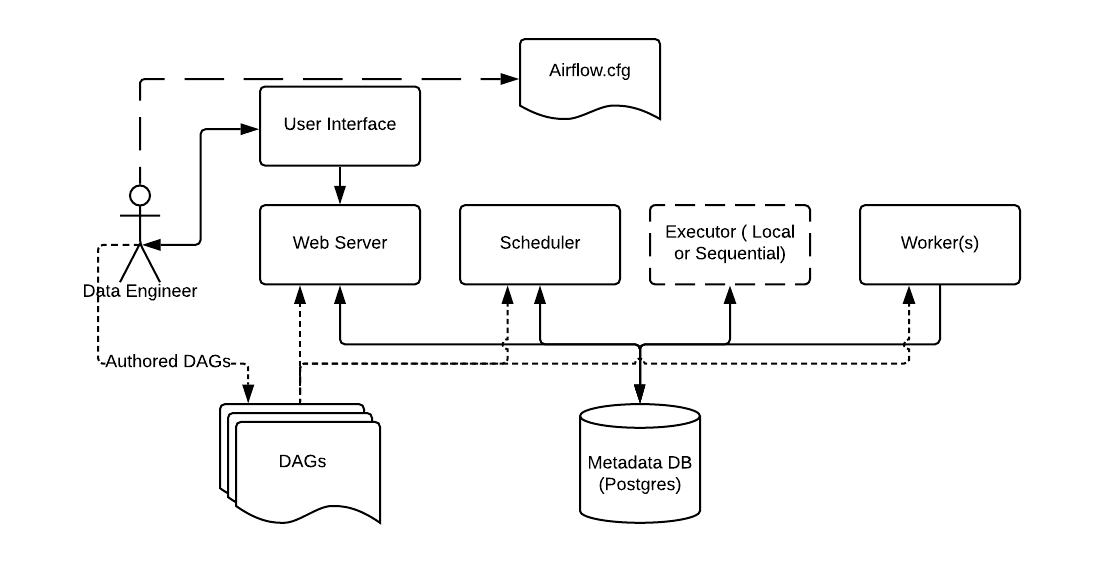

Основные компоненты:

    1) Metadata Database. 
    Airflow использует базу данных SQL для хранения метаданных о запущенных пайплайнах данных. На диаграмме выше это представлено как Postgres.
    
    2) Web Server и Scheduler.
    Веб-сервер Airflow и планировщик - это отдельные процессы, выполняемые (в данном случае) на локальном компьютере и взаимодействующие с упомянутой выше базой данных.
    
    3) Worker. 
    Worker – это место, где запускается наш код и выполняются задачи. Воркеры представляют собой отдельные процессы, которые также взаимодействуют с другими компонентами архитектуры Airflow и репозиторием метаданных.
    
    4) airflow.cfg
    Конфигурационный файл, к которому обращаются веб сервер, планировщик и воркеры.
    
    5) DAG
    Питон файл, представляет собой набор всех задач, которые вы хотите выполнить, организованных таким образом, чтобы отражать их отношения и зависимости. Также можно определить DAG, как направленный ациклический граф.

Важной частью дага, является оператор (operator). Оператор описывает отдельную задачу в рабочем процессе. Операторы обычно (но не всегда) атомарны, то есть они могут работать сами по себе и им не нужно делиться ресурсами с другими операторами. DAG будет следить за тем, чтобы операторы выполнялись в правильном порядке; кроме этих зависимостей, операторы обычно работают независимо. Фактически, они могут работать на двух совершенно разных машинах.

Как правило, если двум операторам необходимо обмениваться информацией, например именем файла или небольшим объемом данных, вам следует подумать о том, чтобы объединить их в один оператор. Если сделать это невозможно, у Airflow есть функция кросс-коммуникаций операторов, называемая XCom.

Пример кода дага:

In [ ]:
from airflow import DAG
from airflow.operators.bash_operator import BashOperator
from datetime import datetime


DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": datetime(2021, 1, 12),
    "retries": 0,
    "email_on_failure": False,
    "email_on_retry": False,
    "depends_on_past": True,
}

with DAG(
    dag_id="test-data-flow",
    default_args=DEFAULT_ARGS,
    schedule_interval="@daily",
    max_active_runs=1,
    tags=['data-flow'],
) as dag1:
    t1 = BashOperator(
        task_id='print_date',
        bash_command='date',
    )

    t2 = BashOperator(
        task_id='sleep',
        depends_on_past=False,
        bash_command='sleep 5',
        retries=3,
    )

    t1 >> t2

Вот так выглядит даг в веб интерфейсе аирфлоу:

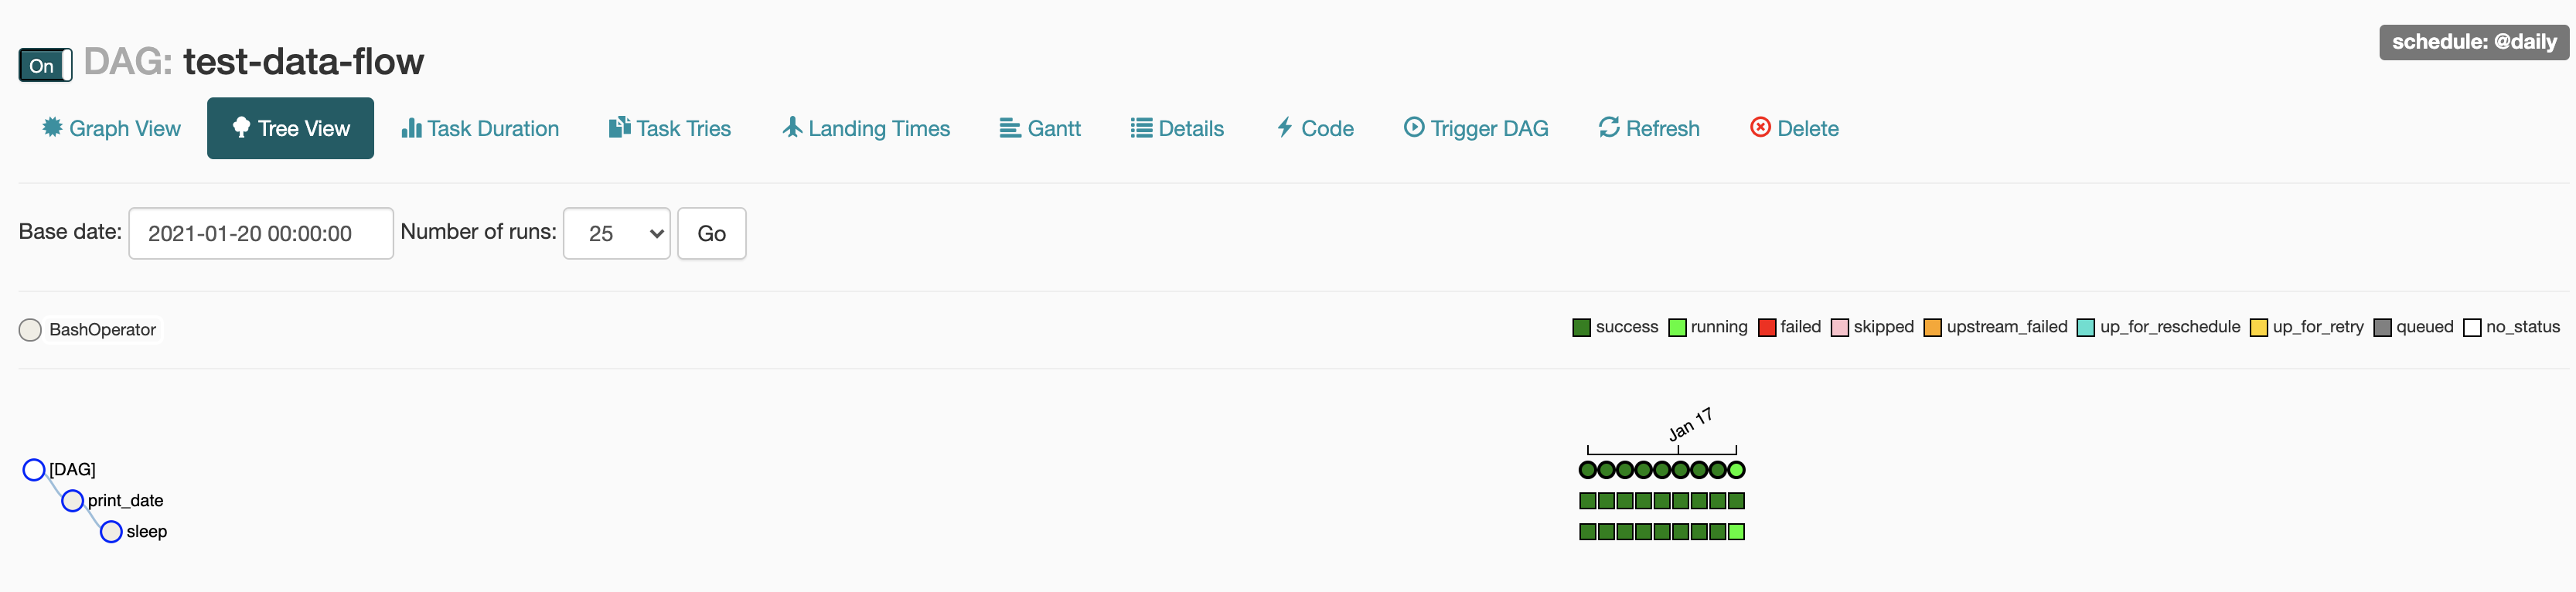

Важной особенностью аирфлоу является идемпотентность. Идемпотентность – это свойство объекта при повторном применении операции к объекту всегда возвращать один и тот же результат. В контексте аирфлоу это значит, что запуская таски из прошлого мы получим тот же результат. Идемпотентнось реализуется с помощью Task Instance. 

Task Instance представляет собой конкретный запуск таска и характеризуется как комбинация дага, таска и момента времени (Execution_date). Task Instance также имеют индикативное состояние, которое может быть "running", "success", "failed", "skipped", "up for retry" и так далее.

Веб нтерфейс взаимодействия с Task Instance (открывается если кликнуть на квадратик):

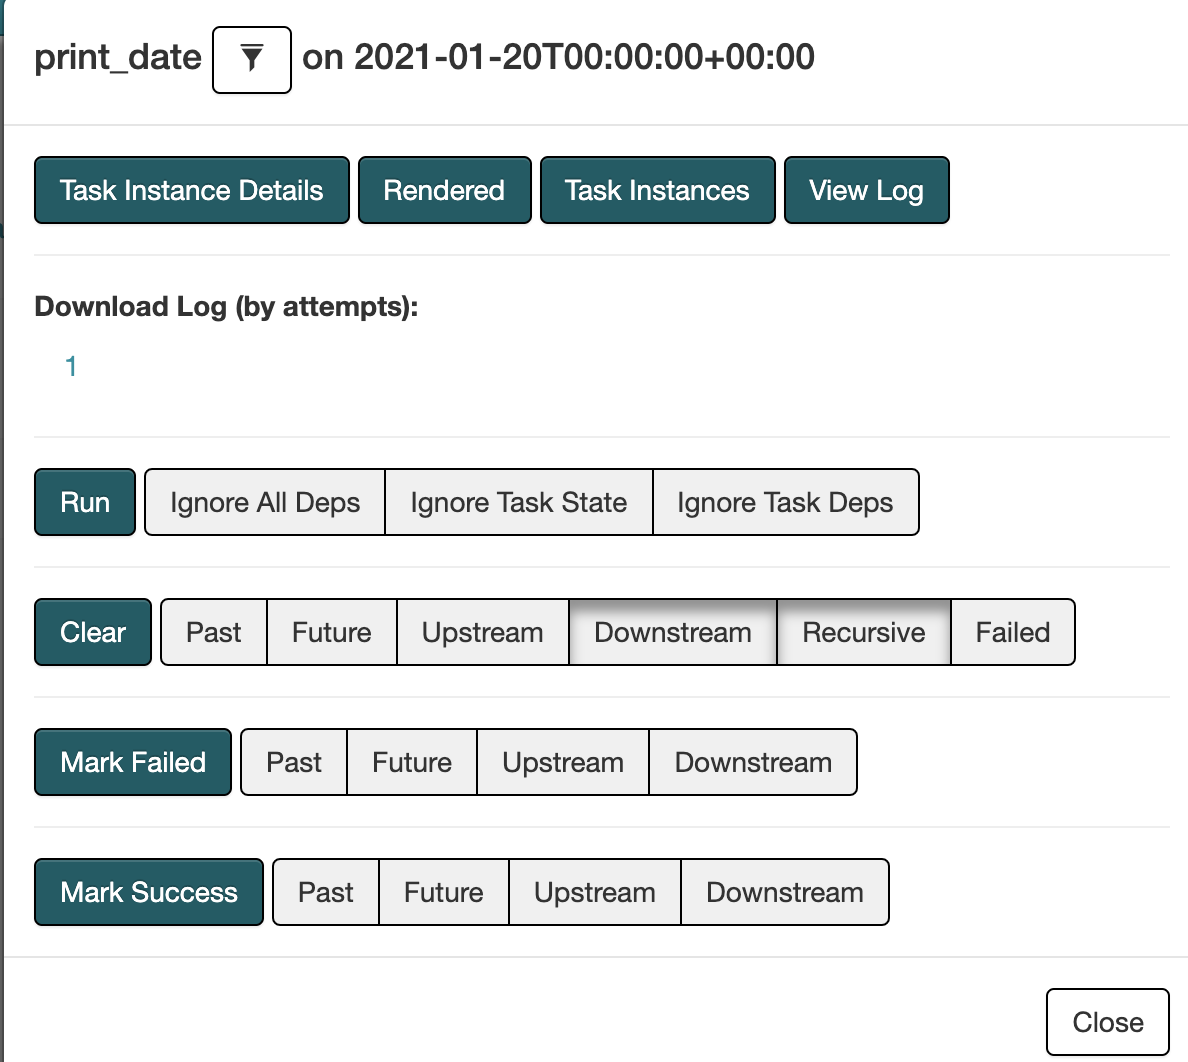

С помощью него можно перезапустить таски за определенную дату, отметить как succes/failed.

Также в интерфейсе арифлоу есть следующие полезные функции:

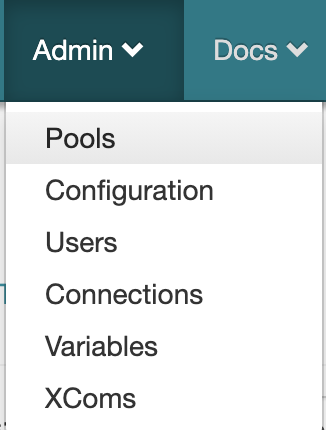

Pools - сущность, в которой хранится информация о максимальном количестве воркеров. Используется для ограничения параллелизма, поскольку не все системы поддерживают большое количество обращений в единицу времени.

Users - сущность, в которой хранится информация о пользователях Airflow.

Connections – сущность, в которой хранится информация о подключении к внешним источникам. В Airflow поддерживается множество источников: от банальных http и ftp, заканчивая популярными базами данных и облачными провайдерами.

Variables – это переменные. Нужны для хранения вещей, которые нужны для запуска пайплайнов.

XCom - функция кросс-коммуникации, расшифровывается как cross-communication. Она создана для передачи данных между задачами: это могут быть название файла, строчка из базы данных или json-объект. Максимальный вес – до 48 килобайт.

## Разворачиваем окружение

Скачиваем образ:
>docker pull puckel/docker-airflow

Создадим файл docker-compose.yml:

Запуск контейнера:
>docker-compose up -d

Веб интерфейс доступен по адресу:
>http://localhost:8080/admin/

# Пишем ETL систему

Airflow позволяет создавать кастомные операторы. Создадим в контейнере директорию operators. Для этого перейдем в bash контейнера:
>docker exec -it *CONTAINER ID* bash
<br>mkdir operators

Создадим файл с базовым оператором data_transfer.py, в котором будет определен механизм загрузки данных:

In [ ]:
import logging
import os
import psycopg2
from airflow.models import BaseOperator
from airflow.utils.decorators import apply_defaults


class DataTransfer(BaseOperator):
    @apply_defaults
    def __init__(self, config, pg_conn_str, *args, **kwargs):
        super(DataTransfer, self).__init__(
            *args,
            **kwargs
        )
        self.config = config
        self.pg_conn_str = pg_conn_str

    def provide_data(self, csv_file, context):
        pass


    def execute(self, context):
        copy_statement = """
        COPY {target_schema}.{target_table} ({columns}) FROM STDIN with
        DELIMITER '\t'
        CSV
        ESCAPE '\\'
        NULL '';
        """
        schema_name = "{table}".format(**self.config).split(".")
        self.config.update(
            target_schema=schema_name[0],
            target_table=schema_name[1],
        )
        with psycopg2.connect(self.pg_conn_str) as conn, conn.cursor() as cursor:
            cursor.execute(
                """
            select column_name
              from information_schema.columns
             where table_schema = '{target_schema}'
               and table_name = '{target_table}';
            """.format(
                    **self.config
                )
            )
            result = cursor.fetchall()
            columns = ", ".join('"{}"'.format(row) for row, in result)
            self.config.update(columns=columns)

            with open("transfer.csv", "w", encoding="utf-8") as csv_file:
                self.provide_data(csv_file, context)

            self.log.info("writing succed")

            with open('transfer.csv', 'r', encoding="utf-8") as f:
                cursor.copy_expert(copy_statement.format(**self.config), f)

Добавим файл postgres.py, который будет содержать в себе оператор извлечения данных из постгреса:

In [ ]:
from operators.data_transfer import DataTransfer
import csv
import psycopg2


class DataTransferPostgres(DataTransfer):
    def __init__(
        self, source_pg_conn_str, query, *args, **kwargs
    ):
        super(DataTransferPostgres, self).__init__(
            source_pg_conn_str=source_pg_conn_str, query=query, *args, **kwargs
        )
        self.source_pg_conn_str = source_pg_conn_str
        self.query = query

    def provide_data(self, csv_file, context):
        pg_conn = psycopg2.connect(self.source_pg_conn_str)
        pg_cursor = pg_conn.cursor()
        query_to_execute = self.query
        self.log.info("Executing query: {}".format(query_to_execute))
        pg_cursor.execute(query_to_execute)
        csvwriter = csv.writer(
            csv_file,
            delimiter="\t",
            quoting=csv.QUOTE_NONE,
            lineterminator="\n",
            escapechar='\\'
        )

        while True:
            rows = pg_cursor.fetchmany(size=1000)
            if rows:
                for row in rows:
                    _row = list(row)
                    csvwriter.writerow(_row)
            else:
                break
        pg_conn.close()

Создадим даг, чтобы протестировать наши операторы:

In [ ]:
from airflow import DAG
from operators.postgres import DataTransferPostgres
from datetime import datetime


DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": datetime(2021, 1, 25),
    "retries": 1,
    "email_on_failure": False,
    "email_on_retry": False,
    "depends_on_past": True,
}

with DAG(
    dag_id="pg-data-flow",
    default_args=DEFAULT_ARGS,
    schedule_interval="@daily",
    max_active_runs=1,
    tags=['data-flow'],
) as dag1:
    t1 = DataTransferPostgres(
        config={'table': 'public.customer'},
        query='select * from customer',
        task_id='customer',
        source_pg_conn_str="host='db2' port=5432 dbname='tpch' user='admin' password='postgres'",
        pg_conn_str="host='db' port=5432 dbname='my_database2' user='postgres' password='postgres'",
    )


Проверим что все работает:

In [2]:
import psycopg2

conn_string= "host='localhost' port=5432 dbname='my_database2' user='admin' password='postgres'" 
with psycopg2.connect(conn_string) as conn, conn.cursor() as cursor:
    cursor.execute('select count(*) from customer')
    print(cursor.fetchall())

[(750007,)]


Подведем итоги:

    • познакомились с Airflow
    • написали базовый оператор ответственный за загрузку данных в хранилище
    • написали оператор извлечения данных из postgres (заменить на нужную СУБД)
    • написали даг ежедневного дампа таблицы в хранилище
    • получили скелет etl системы

Источники:

    • https://docs.python.org/3/library/csv.html
    • https://airflow.apache.org/docs/apache-airflow/stable/concepts.html
    • https://www.postgresql.org/docs/9.1/information-schema.html

## Домашнее задание

1) Развернуть окружение
<br>2) Создать даг для дампа всех таблиц, использую операторы из урока